# CVaR-based MPC vs Deterministic MPC for Oenoferm Freddo with Uncertain Cellar Temperature

This notebook compares two control strategies for wine fermentation:
1. **Deterministic MPC**: Uses nominal (mean) cellar temperature, ignoring uncertainty
2. **CVaR-based MPC**: Risk-averse optimization considering worst-case scenarios

The cellar temperature p[17] varies uniformly between 10°C and 19°C, representing ambient temperature uncertainty.

## Import Libraries

In [28]:
from time import time
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

# Create separate random number generators for fair comparison
# rng_scenarios: Used by CVaR to sample optimization scenarios
# rng_disturbance: Used to generate actual disturbances (same for both controllers)
rng_scenarios = np.random.default_rng(42)
rng_disturbance = np.random.default_rng(123)

## Configuration Parameters

In [ ]:
# ============================================================================
# KINETIC PARAMETERS FOR OENOFERM FREDDO YEAST
# ============================================================================
p_fred = [2.86655, 0.2868, 3.8406, 56.6794, 1.29881, 36.2122, 1.93209, 682.807, 
          5.27951, 2.73182e-06, 0.165704, 0.0020808, 0.0224764, 2.30538, 0.029611, 
          0.00130657, 59.8368, 14.5, 2.0, (23.5/180 *0.8 *178.9)/95, 1.0, 
          0.15841, 0.0434, 0.137399, 0.0577448]

# ============================================================================
# UNCERTAINTY CONFIGURATION 
# ============================================================================

T_cellar_min = 25.0   # Minimum ambient temperature (°C) 
T_cellar_max = 30.0  # Maximum ambient temperature (°C) - As it is a cooling system, we can have higher ambient temperatures
T_cellar_nominal = 14.5  # Nominal temperature for deterministic MPC

p_fred[22] = 0.5 #Increase the ambient cooling influence to make uncertainty more impactful



# ============================================================================
# CVAR CONFIGURATION (MORE RISK-AVERSE)
# ============================================================================
# Lower alpha = more risk-averse 
alpha = 0.05  # CVaR confidence level 
# More scenarios = better coverage of uncertainty space
n_scenarios = 50  # Number of scenarios for CVaR optimization

# ============================================================================
# MPC CONFIGURATION
# ============================================================================
th = 1  # Time step (days)
n = 21  # Prediction horizon (days)
sim_time = 21  # Maximum simulation time (days)




## Define Common System Dynamics

In [30]:
# ============================================================================
# STATE VARIABLES
# ============================================================================
X = SX.sym('X')  # Yeast concentration (g/L)
N = SX.sym('N')  # Nitrogen concentration (g/L)
E = SX.sym('E')  # Ethanol concentration (g/L)
S = SX.sym('S')  # Sugar concentration (g/L)
O = SX.sym('O')  # Oxygen concentration (g/L)
T = SX.sym('T')  # Temperature (°C)

states = vertcat(X, N, E, S, O, T)
n_states = states.numel()

# ============================================================================
# CONTROL VARIABLES
# ============================================================================
w = SX.sym('w')  # Temperature control input (0 to 1)
controls = vertcat(w)
n_controls = controls.numel()

# ============================================================================
# PARAMETRIC CELLAR TEMPERATURE
# ============================================================================
T_cellar = SX.sym('T_cellar')  # Parametric cellar temperature

def create_rhs(p_vals, T_cellar_param):
    """Create RHS of ODEs with parametric cellar temperature"""
    p = p_vals.copy()
    p[17] = T_cellar_param

    rhs = vertcat(
        # dX/dt: Change in Yeast concentration
        # Yeast growth is modeled using Monod kinetics (saturation model)
        # - Growth term: (p[0]*T-p[1]) is temperature-dependent maximum growth rate
        #   multiplied by Monod saturation terms for N, S, and O availability
        # - Death term: -p[24]*X represents natural yeast death
        # - Inhibition term: -(0.5 + 1/π*arctan(...)) represents ethanol inhibition
        #   as ethanol concentration (E) increases, it inhibits yeast growth
        (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X
        - p[24] * X
        - (0.5 + 1 / pi * arctan(p[10] * (E - p[16]))) * p[11] * (E - p[16]) ** 2 * X,
        # dN/dt: Change in Nitrogen concentration
        # Nitrogen is consumed proportionally to yeast growth rate
        # p[12] is the stoichiometric coefficient (how much N is needed per unit yeast growth)
        # The negative sign indicates consumption (decrease in concentration)
        -p[12]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X,
        # dE/dt: Change in Ethanol concentration
        # Ethanol is produced from sugar consumption at a rate dependent on temperature
        # (p[2]*T-p[3]) is temperature-dependent maximum ethanol production rate
        # The rate depends on sugar availability S/(p[8]+S) and accumulated ethanol E
        (p[2] * T - p[3])
        * (S / (p[8] + S))
        * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
        * X,
        # dS/dt: Change in Sugar concentration
        # Sugar is consumed via two pathways:
        # 1. For ethanol production: -p[13] * (ethanol production rate)
        # 2. For yeast maintenance/growth: -p[14] * (growth rate)
        # Both terms are negative because sugar is being consumed (decreasing)
        -p[13]
        * (p[2] * T - p[3])
        * (S / (p[8] + S))
        * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
        * X
        - p[14]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X,
        # dO/dt: Change in Oxygen concentration
        # Oxygen is consumed during yeast growth and respiration
        # p[15] is the stoichiometric coefficient for oxygen consumption
        -p[15]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * (O / (p[9] + O))
        * X,
        # dT/dt: Change in Temperature (Temperature dynamics)
        # Temperature change depends on:
        # 1. Heat generated by ethanol production: p[19] * (ethanol production rate)
        # 2. Heat consumed by oxygen consumption: -p[20] * (oxygen consumption rate)
        # 3. Active heating from control w: -p[21]*(T-p[18])*w
        #    If T < p[18] (temperature of the coolant (cooling medium)), heating control w increases temperature
        # 4. Passive cooling to ambient: -p[22]*(T-p[17])
        #    If T > p[17] (lower limit), system naturally cools down
        p[19]
        * (
            (p[2] * T - p[3])
            * (S / (p[8] + S))
            * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
            * X
            - p[20]
            * (
                -p[15]
                * (p[0] * T - p[1])
                * (N / (p[6] + N))
                * (S / (p[7] + S))
                * (O / (p[9] + O))
                * X
            )
            - p[21] * (T - p[18]) * w
            - p[22] * (T - p[17])
        ),
    )
    return rhs

rhs = create_rhs(p_fred, T_cellar)
f = Function('f', [states, controls, T_cellar], [rhs])

print("Parametric dynamics function created")

Parametric dynamics function created


## Utility Functions

In [31]:
def shift_timestep(step_horizon, t0, state_init, u, T_cellar_realized, f_dyn):
    # step_horizon: Time step duration (days)
    # t0: Current simulation time (days)
    # state_init: Current state [X, N, E, S, O, T] (6×1 CasADi DM)
    # u: Control sequence over horizon (1×21)
    # T_cellar_realized: Actual cellar temperature (°C, sampled from uncertainty)
    # f_dyn: ODE function f(states, controls, T_cellar)
    """Advance system by one time step"""
    k1 = f_dyn(state_init, u[:, 0], T_cellar_realized)
    k2 = f_dyn(state_init + step_horizon/2*k1, u[:, 0], T_cellar_realized)
    k3 = f_dyn(state_init + step_horizon/2*k2, u[:, 0], T_cellar_realized)
    k4 = f_dyn(state_init + step_horizon*k3, u[:, 0], T_cellar_realized)

    next_state = state_init + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
    t0 = t0 + step_horizon

    u0 = horzcat(u[:, 1:], reshape(u[:, -1], -1, 1))
    return t0, next_state, u0

def DM2Arr(dm):
    """Convert CasADi DM to numpy array"""
    if isinstance(dm, np.ndarray):
        return dm
    return np.array(dm.full())

def sample_cellar_temperatures(n_samples, rng):
    """Sample cellar temperatures from uniform distribution using specified RNG"""
    return rng.uniform(T_cellar_min, T_cellar_max, n_samples)

def sample_actual_disturbance(rng):
    """Sample actual disturbance temperature using specified RNG"""
    return rng.uniform(T_cellar_min, T_cellar_max)

print("Utility functions defined")

Utility functions defined


## Build Deterministic MPC Solver

In [32]:
# ============================================================================
# DETERMINISTIC MPC (Uses Nominal Cellar Temperature)
# ============================================================================

# Decision variables
Y_det = SX.sym('Y_det', n_states, n + 1)  # State trajectory (6×22): [X,N,E,S,O,T] over 21 days + initial
U_det = SX.sym('U_det', n_controls, n)    # Control sequence (1×21): w[0]...w[20]
P_det = SX.sym('P_det', n_states + 1)     # Parameters: [initial_state(6), target_sugar(1)]

# Forward simulation with nominal cellar temperature (14.5°C)
Y_det[:, 0] = P_det[:n_states]  # Set initial state from parameters
for k in range(n):
    st = Y_det[:, k]    # Current state
    con = U_det[:, k]   # Current control
    
    # RK4 integration: predict next state assuming T_cellar = 14.5°C (ignores uncertainty)
    k1 = f(st, con, T_cellar_nominal)
    k2 = f(st + th/2*k1, con, T_cellar_nominal)
    k3 = f(st + th/2*k2, con, T_cellar_nominal)
    k4 = f(st + th*k3, con, T_cellar_nominal)
    
    Y_det[:, k+1] = st + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)

# Objective function: minimize control effort + tracking error
cost_det = 0
for k in range(n):
    st = Y_det[3, k]      # Sugar concentration at day k
    con = U_det[:, k]      # Control at day k
    # Compute linear reference sugar profile
    # This is a desired trajectory from initial sugar Y[3,0] to target P[n_states]
    # S_dach represents where we want sugar to be at time step k
    # Linear interpolation: starts at current value, ends at target, uniformly over n steps
    S_dach = ((P_det[n_states] - Y_det[3, 0])/n)*(k*th) + Y_det[3, 0]  # Linear sugar profile

    # Accumulate cost from three terms:
    # 1. Control cost: 1*con*p[18]
    #    - Penalizes large temperature control inputs
    #    - p[18]=2.0 is the weighting factor
    #    - Encourages smooth, minimal control adjustments
    #
    # 2. Tracking error cost: 1*(st-P[n_states])**2
    #    - Penalizes deviation from target sugar concentration
    #    - Squared term makes large errors more costly (non-linear penalty)
    #    - P[n_states] is the target (usually 0 for complete fermentation)
    #    - Weight = 1 means this is the primary objective
    #
    # 3. Reference tracking cost: 0.01*(st-S_dach)**2
    #    - Penalizes deviation from the linear reference profile
    #    - Encourages steady, linear progress toward the target
    #    - Weight = 0.01 is smaller, so this is secondary to reaching target
    cost_det = cost_det + 1*con*p_fred[18] + 1*(st - P_det[n_states])**2 + 0.01*(st - S_dach)**2

# State constraints: physical bounds on each state variable
g_det = []
for k in range(n):
    # Collect all 6 states at each time step for constraint evaluation
    g_det.extend([Y_det[0, k], Y_det[1, k], Y_det[2, k], 
                  Y_det[3, k], Y_det[4, k], Y_det[5, k]])
g_det = vertcat(*g_det)

# Constraint bounds for all time steps
lbg_det = []  # Lower bounds
ubg_det = []  # Upper bounds
for k in range(n):
    # [X≥0, N≥0, E≥0, S≥0, O≥-0.1, T≥13°C]
    lbg_det.extend([0, 0, 0, 0, -0.1, 13])
    # [X≤∞, N≤∞, E≤∞, S≤178.9, O≤∞, T≤25°C]
    ubg_det.extend([inf, inf, inf, 178.9, inf, 25])

# Formulate nonlinear program (NLP)
nlp_det = {
    'f': cost_det,                      # Objective: minimize cost
    'x': U_det.reshape((-1, 1)),        # Decision variables: 21 controls (reshaped to column)
    'g': g_det,                         # Constraints: state bounds over horizon
    'p': P_det                          # Parameters: initial state + target
}

# Solver options
opts_det = {
    'ipopt': {'max_iter': 2000, 'print_level': 0, 'acceptable_tol': 1e-6},  # IPOPT settings
    'print_time': 0  # Suppress timing output
}

# Create NLP solver using IPOPT
solver_det = nlpsol('solver_det', 'ipopt', nlp_det, opts_det)

print(f"Deterministic MPC solver created (using T_cellar = {T_cellar_nominal}°C)")

Deterministic MPC solver created (using T_cellar = 14.5°C)


## Build CVaR-based MPC Solver

In [33]:
# ============================================================================
# CVAR-BASED MPC 
# ============================================================================

U_cvar = SX.sym('U_cvar', n_controls, n)
P_cvar = SX.sym('P_cvar', n_states + 1 + n_scenarios)  # State + target + scenarios
eta = SX.sym('eta')  # VaR
z = SX.sym('z', n_scenarios)  # CVaR auxiliaries

# Extract scenario temperatures from parameters
T_scenarios = P_cvar[n_states+1:]

# Simulate each scenario
costs_cvar = []
g_cvar = []

for s in range(n_scenarios):
    Y_s = SX.sym(f'Y_s{s}', n_states, n + 1)
    Y_s[:, 0] = P_cvar[:n_states]
    
    # Forward simulation for scenario s
    for k in range(n):
        st = Y_s[:, k]
        con = U_cvar[:, k]
        T_c = T_scenarios[s]
        
        k1 = f(st, con, T_c)
        k2 = f(st + th/2*k1, con, T_c)
        k3 = f(st + th/2*k2, con, T_c)
        k4 = f(st + th*k3, con, T_c)
        
        Y_s[:, k+1] = st + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    # Compute cost for scenario s
    cost_s = 0
    for k in range(n):
        st = Y_s[3, k]
        con = U_cvar[:, k]
        S_dach = ((P_cvar[n_states] - Y_s[3, 0])/n)*(k*th) + Y_s[3, 0]
        cost_s = cost_s + 1*con*p_fred[18] + 1*(st - P_cvar[n_states])**2 + 0.01*(st - S_dach)**2
    
    costs_cvar.append(cost_s)
    
    # State constraints for scenario s
    for k in range(n):
        g_cvar.extend([Y_s[0, k], Y_s[1, k], Y_s[2, k], 
                       Y_s[3, k], Y_s[4, k], Y_s[5, k]])

# CVaR objective
cvar_obj = eta + (1.0/(alpha * n_scenarios)) * sum(z)

# CVaR constraints: z[s] >= cost[s] - eta
for s in range(n_scenarios):
    g_cvar.append(z[s] - (costs_cvar[s] - eta))

g_cvar = vertcat(*g_cvar)

# Bounds
lbg_cvar = []
ubg_cvar = []
for s in range(n_scenarios):
    for k in range(n):
        lbg_cvar.extend([0, 0, 0, 0, -0.1, 13])
        ubg_cvar.extend([inf, inf, inf, 178.9, inf, 25])
# CVaR constraint bounds
lbg_cvar.extend([0] * n_scenarios)
ubg_cvar.extend([inf] * n_scenarios)

# Decision variable bounds
lbx_cvar = [0] * (n_controls * n) + [-inf] + [0] * n_scenarios
ubx_cvar = [1] * (n_controls * n) + [inf] + [inf] * n_scenarios

nlp_cvar = {
    'f': cvar_obj,
    'x': vertcat(U_cvar.reshape((-1, 1)), eta, z),
    'g': g_cvar,
    'p': P_cvar
}

opts_cvar = {
    'ipopt': {'max_iter': 3000, 'print_level': 0, 'acceptable_tol': 1e-6},
    'print_time': 0
}

solver_cvar = nlpsol('solver_cvar', 'ipopt', nlp_cvar, opts_cvar)

print(f"CVaR-based MPC solver created (α={alpha}, {n_scenarios} scenarios)")

CVaR-based MPC solver created (α=0.05, 50 scenarios)


In [34]:
SAMPLE_DAILY = True
TEMPERATURE_DAILY = 8

## Run Deterministic MPC

In [35]:
print("="*80)
print("Running DETERMINISTIC MPC")
print("="*80)

# Reset disturbance RNG for reproducible comparison
rng_disturbance = np.random.default_rng(123)

t0_det = 0
y0_det = DM([0.20, 0.098, 0.0, 178.9, 0.005, 18])
Sref = DM([0])

t_hist_det = [float(t0_det)]
y_hist_det = [DM2Arr(y0_det).flatten()]
u_hist_det = []
T_cellar_realized_det = []
cost_hist_det = []

u0_det = DM.zeros((n, n_controls))
mpciter = 0

while (float(y0_det[3] - Sref) > 0) and (mpciter * th < sim_time):
    if mpciter % 5 == 0:
        print(f"Day {mpciter}: Sugar = {float(y0_det[3]):.2f} g/L")
    
    # Solve deterministic MPC
    sol_det = solver_det(
        x0=u0_det.reshape((-1, 1)),
        lbx=0, ubx=1,
        lbg=DM(lbg_det), ubg=DM(ubg_det),
        p=vertcat(y0_det, Sref)
    )
    
    u_det = reshape(sol_det['x'], n_controls, n)
    
    # Sample ACTUAL cellar temperature (unknown to controller)
    if SAMPLE_DAILY:
        T_cellar_actual = sample_actual_disturbance(rng_disturbance)
    else:
        T_cellar_actual = TEMPERATURE_DAILY
    # Apply control with actual temperature
    t0_det, y0_det, u0_det = shift_timestep(th, t0_det, y0_det, u_det, T_cellar_actual, f)
    
    if y0_det[4] < 0:
        y0_det[4] = 0
    
    # Store history
    t_hist_det.append(float(t0_det))
    y_hist_det.append(DM2Arr(y0_det).flatten())
    u_hist_det.append(float(u_det[0, 0]))
    T_cellar_realized_det.append(T_cellar_actual)
    cost_hist_det.append(float(sol_det['f']))
    
    mpciter += 1

print(f"\nDeterministic MPC completed in {mpciter} iterations")
print(f"Final sugar: {y_hist_det[-1][3]:.4f} g/L")
print(f"Final ethanol: {y_hist_det[-1][2]:.4f} g/L")

Running DETERMINISTIC MPC
Day 0: Sugar = 178.90 g/L
Day 5: Sugar = 126.03 g/L
Day 10: Sugar = 78.88 g/L
Day 15: Sugar = 46.90 g/L
Day 20: Sugar = 22.55 g/L

Deterministic MPC completed in 21 iterations
Final sugar: 19.0006 g/L
Final ethanol: 69.3103 g/L


## Run CVaR-based MPC

In [36]:
print("\n" + "="*80)
print("Running CVAR-BASED MPC")
print("="*80)

# Reset disturbance RNG to ensure same sequence as deterministic
rng_disturbance = np.random.default_rng(123)

t0_cvar = 0
y0_cvar = DM([0.20, 0.098, 0.0, 178.9, 0.005, 18])

t_hist_cvar = [float(t0_cvar)]
y_hist_cvar = [DM2Arr(y0_cvar).flatten()]
u_hist_cvar = []
T_cellar_realized_cvar = []
cvar_hist = []
eta_hist = []

u0_cvar = DM.zeros((n, n_controls))
eta0 = DM(0)
z0 = DM.zeros(n_scenarios)
mpciter = 0

while (float(y0_cvar[3] - Sref) > 0) and (mpciter * th < sim_time):
    if mpciter % 5 == 0:
        print(f"Day {mpciter}: Sugar = {float(y0_cvar[3]):.2f} g/L")
    
    # Sample scenarios for optimization using separate RNG
    T_scenarios_sample = sample_cellar_temperatures(n_scenarios, rng_scenarios)
    
    # Solve CVaR MPC
    sol_cvar = solver_cvar(
        x0=vertcat(u0_cvar.reshape((-1, 1)), eta0, z0),
        lbx=DM(lbx_cvar), ubx=DM(ubx_cvar),
        lbg=DM(lbg_cvar), ubg=DM(ubg_cvar),
        p=vertcat(y0_cvar, Sref, DM(T_scenarios_sample))
    )
    
    sol_x = sol_cvar['x']
    u_cvar = reshape(sol_x[:n_controls*n], n_controls, n)
    eta_opt = sol_x[n_controls*n]
    z_opt = sol_x[n_controls*n+1:]
    
    # Sample ACTUAL cellar temperature using SAME disturbance RNG as deterministic
    if SAMPLE_DAILY:
        T_cellar_actual = sample_actual_disturbance(rng_disturbance)
    else:
        T_cellar_actual = TEMPERATURE_DAILY
    # Apply control with actual temperature
    t0_cvar, y0_cvar, u0_cvar = shift_timestep(th, t0_cvar, y0_cvar, u_cvar, T_cellar_actual, f)
    
    if y0_cvar[4] < 0:
        y0_cvar[4] = 0
    
    eta0 = eta_opt
    z0 = z_opt
    
    # Store history
    t_hist_cvar.append(float(t0_cvar))
    y_hist_cvar.append(DM2Arr(y0_cvar).flatten())
    u_hist_cvar.append(float(u_cvar[0, 0]))
    T_cellar_realized_cvar.append(T_cellar_actual)
    cvar_hist.append(float(sol_cvar['f']))
    eta_hist.append(float(eta_opt))
    
    mpciter += 1

print(f"\nCVaR-based MPC completed in {mpciter} iterations")
print(f"Final sugar: {y_hist_cvar[-1][3]:.4f} g/L")
print(f"Final ethanol: {y_hist_cvar[-1][2]:.4f} g/L")


Running CVAR-BASED MPC
Day 0: Sugar = 178.90 g/L
Day 5: Sugar = 129.20 g/L
Day 10: Sugar = 75.84 g/L
Day 15: Sugar = 41.53 g/L
Day 20: Sugar = 17.79 g/L

CVaR-based MPC completed in 21 iterations
Final sugar: 14.8154 g/L
Final ethanol: 71.1280 g/L


In [37]:
# ============================================================================
# SIDE-BY-SIDE PROGRESS COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("SIDE-BY-SIDE CONTROL PROGRESS COMPARISON")
print("=" * 80)

# Convert to numpy arrays for easier indexing
y_hist_det_arr = np.array(y_hist_det)
y_hist_cvar_arr = np.array(y_hist_cvar)

# Determine iteration count for comparison
max_iters = min(len(u_hist_det), len(u_hist_cvar))

# Header
print(f"\n{'Day':<6}{'Deterministic MPC':<40}{'CVaR-based MPC':<40}")
print(
    f"{'':6}{'Sugar (g/L)':<15}{'Control w':<12}{'Temp (°C)':<13}"
    f"{'Sugar (g/L)':<15}{'Control w':<12}{'Temp (°C)':<13}"
)
print("-" * 86)

# Print comparison for every 2 days
for i in range(0, max_iters, 2):
    det_sugar = y_hist_det_arr[i, 3]
    det_control = u_hist_det[i] if i < len(u_hist_det) else 0
    det_temp = y_hist_det_arr[i, 5]

    cvar_sugar = y_hist_cvar_arr[i, 3]
    cvar_control = u_hist_cvar[i] if i < len(u_hist_cvar) else 0
    cvar_temp = y_hist_cvar_arr[i, 5]

    print(
        f"{i:<6}{det_sugar:<15.2f}{det_control:<12.4f}{det_temp:<13.2f}"
        f"{cvar_sugar:<15.2f}{cvar_control:<12.4f}{cvar_temp:<13.2f}"
    )

# Final comparison
print("-" * 86)
print(
    f"{'FINAL':<6}{y_hist_det_arr[-1, 3]:<15.4f}{u_hist_det[-1]:<12.4f}{y_hist_det_arr[-1, 5]:<13.2f}"
    f"{y_hist_cvar_arr[-1, 3]:<15.4f}{u_hist_cvar[-1]:<12.4f}{y_hist_cvar_arr[-1, 5]:<13.2f}"
)

# Summary metrics
print("\n" + "=" * 80)
print("CONTROL STRATEGY SUMMARY")
print("=" * 80)

det_avg_control = np.mean(u_hist_det)
cvar_avg_control = np.mean(u_hist_cvar)
det_total_error = np.sum((y_hist_det_arr[:, 3] - 0) ** 2)
cvar_total_error = np.sum((y_hist_cvar_arr[:, 3] - 0) ** 2)

print(f"\n{'Metric':<35}{'Deterministic':<20}{'CVaR':<20}{'Difference':<15}")
print("-" * 90)
print(
    f"{'Total Tracking Error (Σ(S-0)²):':<35}{det_total_error:<20.2f}{cvar_total_error:<20.2f}"
    f"{(cvar_total_error - det_total_error):<+15.2f}"
)
print(
    f"{'Final Sugar Residual (g/L):':<35}{y_hist_det_arr[-1, 3]:<20.4f}{y_hist_cvar_arr[-1, 3]:<20.4f}"
    f"{(y_hist_cvar_arr[-1, 3] - y_hist_det_arr[-1, 3]):<+15.4f}"
)
print(
    f"{'Final Ethanol (g/L):':<35}{y_hist_det_arr[-1, 2]:<20.4f}{y_hist_cvar_arr[-1, 2]:<20.4f}"
    f"{(y_hist_cvar_arr[-1, 2] - y_hist_det_arr[-1, 2]):<+15.4f}"
)


SIDE-BY-SIDE CONTROL PROGRESS COMPARISON

Day   Deterministic MPC                       CVaR-based MPC                          
      Sugar (g/L)    Control w   Temp (°C)    Sugar (g/L)    Control w   Temp (°C)    
--------------------------------------------------------------------------------------
0     178.90         -0.0000     18.00        178.90         1.0000      18.00        
2     161.97         -0.0000     20.89        163.47         1.0000      19.81        
4     138.18         0.9235      23.65        141.56         1.0000      21.56        
6     114.48         1.0000      24.96        116.74         1.0000      23.39        
8     94.75          0.9855      25.70        94.11          1.0000      24.69        
10    78.88          1.0000      26.22        75.84          1.0000      25.61        
12    65.32          0.9913      26.01        60.90          1.0000      25.65        
14    52.81          0.9847      25.90        47.68          1.0000      25.66        


## Comparison Visualization

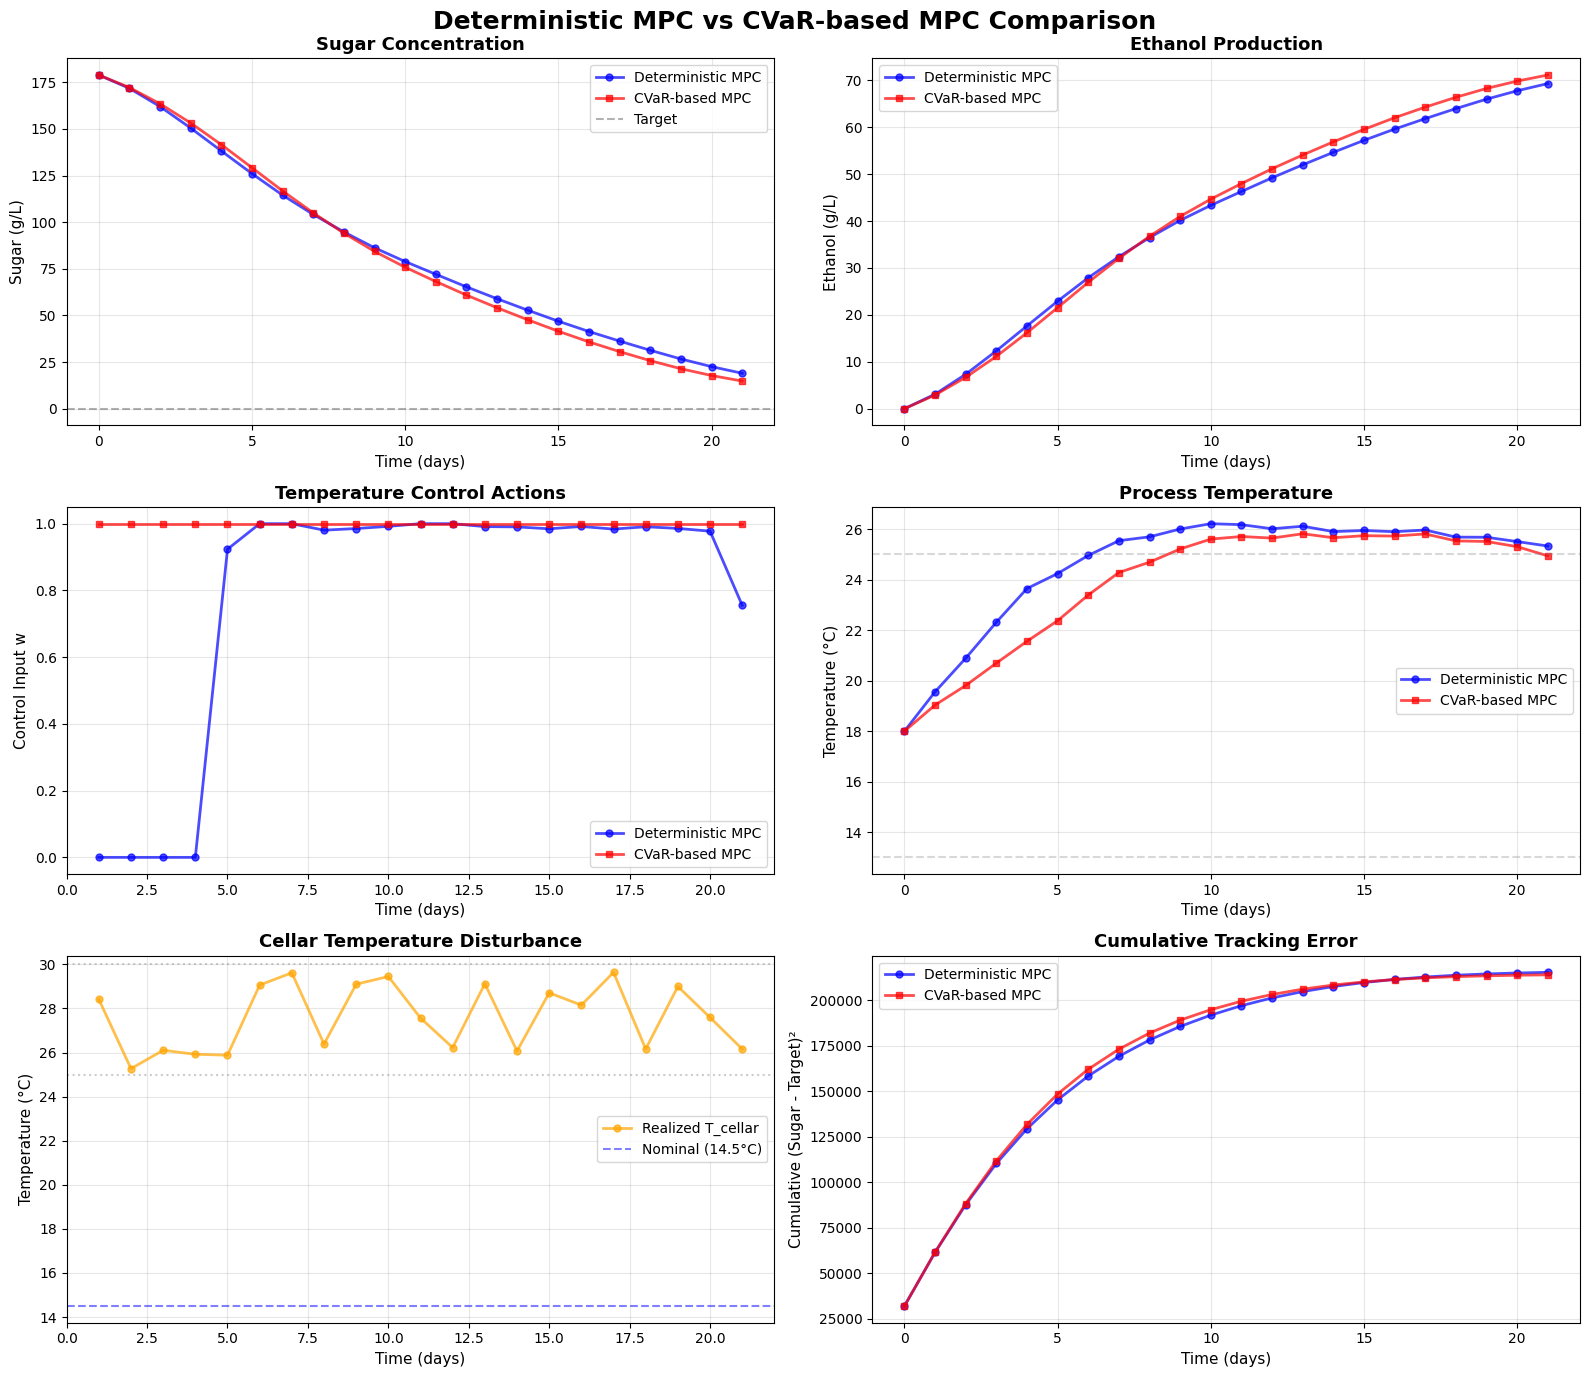

In [38]:
# Convert to arrays
y_hist_det = np.array(y_hist_det)
y_hist_cvar = np.array(y_hist_cvar)
t_hist_det_arr = np.array(t_hist_det)
t_hist_cvar_arr = np.array(t_hist_cvar)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Deterministic MPC vs CVaR-based MPC Comparison', fontsize=18, fontweight='bold')

# Plot 1: Sugar concentration comparison
ax = axes[0, 0]
ax.plot(t_hist_det_arr, y_hist_det[:, 3], 'b-o', linewidth=2, markersize=5, label='Deterministic MPC', alpha=0.7)
ax.plot(t_hist_cvar_arr, y_hist_cvar[:, 3], 'r-s', linewidth=2, markersize=5, label='CVaR-based MPC', alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Target')
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Sugar (g/L)', fontsize=11)
ax.set_title('Sugar Concentration', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Ethanol production comparison
ax = axes[0, 1]
ax.plot(t_hist_det_arr, y_hist_det[:, 2], 'b-o', linewidth=2, markersize=5, label='Deterministic MPC', alpha=0.7)
ax.plot(t_hist_cvar_arr, y_hist_cvar[:, 2], 'r-s', linewidth=2, markersize=5, label='CVaR-based MPC', alpha=0.7)
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Ethanol (g/L)', fontsize=11)
ax.set_title('Ethanol Production', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Control actions comparison
ax = axes[1, 0]
ax.plot(t_hist_det_arr[1:], u_hist_det, 'b-o', linewidth=2, markersize=5, label='Deterministic MPC', alpha=0.7)
ax.plot(t_hist_cvar_arr[1:], u_hist_cvar, 'r-s', linewidth=2, markersize=5, label='CVaR-based MPC', alpha=0.7)
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Control Input w', fontsize=11)
ax.set_title('Temperature Control Actions', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.05, 1.05])

# Plot 4: Process temperature comparison
ax = axes[1, 1]
ax.plot(t_hist_det_arr, y_hist_det[:, 5], 'b-o', linewidth=2, markersize=5, label='Deterministic MPC', alpha=0.7)
ax.plot(t_hist_cvar_arr, y_hist_cvar[:, 5], 'r-s', linewidth=2, markersize=5, label='CVaR-based MPC', alpha=0.7)
ax.axhline(y=13, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Temperature (°C)', fontsize=11)
ax.set_title('Process Temperature', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 5: Realized cellar temperature (both see same disturbance)
ax = axes[2, 0]
ax.plot(t_hist_det_arr[1:], T_cellar_realized_det, 'orange', linewidth=2, marker='o', 
        markersize=5, label='Realized T_cellar', alpha=0.7)
ax.axhline(y=T_cellar_nominal, color='b', linestyle='--', alpha=0.5, label=f'Nominal ({T_cellar_nominal}°C)')
ax.axhline(y=T_cellar_min, color='gray', linestyle=':', alpha=0.4)
ax.axhline(y=T_cellar_max, color='gray', linestyle=':', alpha=0.4)
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Temperature (°C)', fontsize=11)
ax.set_title('Cellar Temperature Disturbance', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 6: Cumulative tracking error
ax = axes[2, 1]
cum_error_det = np.cumsum((y_hist_det[:, 3] - 0)**2)
cum_error_cvar = np.cumsum((y_hist_cvar[:, 3] - 0)**2)
ax.plot(t_hist_det_arr, cum_error_det, 'b-o', linewidth=2, markersize=5, 
        label='Deterministic MPC', alpha=0.7)
ax.plot(t_hist_cvar_arr, cum_error_cvar, 'r-s', linewidth=2, markersize=5, 
        label='CVaR-based MPC', alpha=0.7)
ax.set_xlabel('Time (days)', fontsize=11)
ax.set_ylabel('Cumulative (Sugar - Target)²', fontsize=11)
ax.set_title('Cumulative Tracking Error', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Quantitative Comparison

In [39]:
print("\n" + "="*80)
print("QUANTITATIVE COMPARISON")
print("="*80)

print("\n" + "-"*40)
print("DETERMINISTIC MPC")
print("-"*40)
print(f"Final sugar concentration: {y_hist_det[-1, 3]:.4f} g/L")
print(f"Final ethanol concentration: {y_hist_det[-1, 2]:.4f} g/L")
print(f"Total tracking error (Σ(S-target)²): {np.sum((y_hist_det[:, 3] - 0)**2):.2f}")
print(f"Mean control effort: {np.mean(u_hist_det):.4f}")
print(f"Max control effort: {np.max(u_hist_det):.4f}")
print(f"Control variance: {np.var(u_hist_det):.6f}")

print("\n" + "-"*40)
print("CVAR-BASED MPC")
print("-"*40)
print(f"Final sugar concentration: {y_hist_cvar[-1, 3]:.4f} g/L")
print(f"Final ethanol concentration: {y_hist_cvar[-1, 2]:.4f} g/L")
print(f"Total tracking error (Σ(S-target)²): {np.sum((y_hist_cvar[:, 3] - 0)**2):.2f}")
print(f"Mean control effort: {np.mean(u_hist_cvar):.4f}")
print(f"Max control effort: {np.max(u_hist_cvar):.4f}")
print(f"Control variance: {np.var(u_hist_cvar):.6f}")
print(f"Mean CVaR value: {np.mean(cvar_hist):.4f}")
print(f"Mean VaR value: {np.mean(eta_hist):.4f}")

print("\n" + "-"*40)
print("IMPROVEMENT (CVaR vs Deterministic)")
print("-"*40)
error_improvement = ((np.sum((y_hist_det[:, 3] - 0)**2) - 
                      np.sum((y_hist_cvar[:, 3] - 0)**2)) / 
                     np.sum((y_hist_det[:, 3] - 0)**2) * 100)
print(f"Tracking error reduction: {error_improvement:.2f}%")

control_change = ((np.mean(u_hist_cvar) - np.mean(u_hist_det)) / 
                  np.mean(u_hist_det) * 100)
print(f"Control effort change: {control_change:+.2f}%")

print("\n" + "-"*40)
print("ROBUSTNESS ANALYSIS")
print("-"*40)
print(f"Cellar temperature statistics (same for both):")
print(f"  Mean: {np.mean(T_cellar_realized_det):.2f}°C")
print(f"  Std:  {np.std(T_cellar_realized_det):.2f}°C")
print(f"  Range: [{np.min(T_cellar_realized_det):.2f}, {np.max(T_cellar_realized_det):.2f}]°C")
print(f"\nTemperature constraint violations:")
print(f"  Deterministic: {np.sum((y_hist_det[:, 5] < 13) | (y_hist_det[:, 5] > 25))} violations")
print(f"  CVaR-based:    {np.sum((y_hist_cvar[:, 5] < 13) | (y_hist_cvar[:, 5] > 25))} violations")

print("\n" + "="*80)


QUANTITATIVE COMPARISON

----------------------------------------
DETERMINISTIC MPC
----------------------------------------
Final sugar concentration: 19.0006 g/L
Final ethanol concentration: 69.3103 g/L
Total tracking error (Σ(S-target)²): 215451.44
Mean control effort: 0.7873
Max control effort: 1.0000
Control variance: 0.148459

----------------------------------------
CVAR-BASED MPC
----------------------------------------
Final sugar concentration: 14.8154 g/L
Final ethanol concentration: 71.1280 g/L
Total tracking error (Σ(S-target)²): 214089.48
Mean control effort: 1.0000
Max control effort: 1.0000
Control variance: 0.000000
Mean CVaR value: 265127.8467
Mean VaR value: 264894.1108

----------------------------------------
IMPROVEMENT (CVaR vs Deterministic)
----------------------------------------
Tracking error reduction: 0.63%
Control effort change: +27.02%

----------------------------------------
ROBUSTNESS ANALYSIS
----------------------------------------
Cellar temperatu

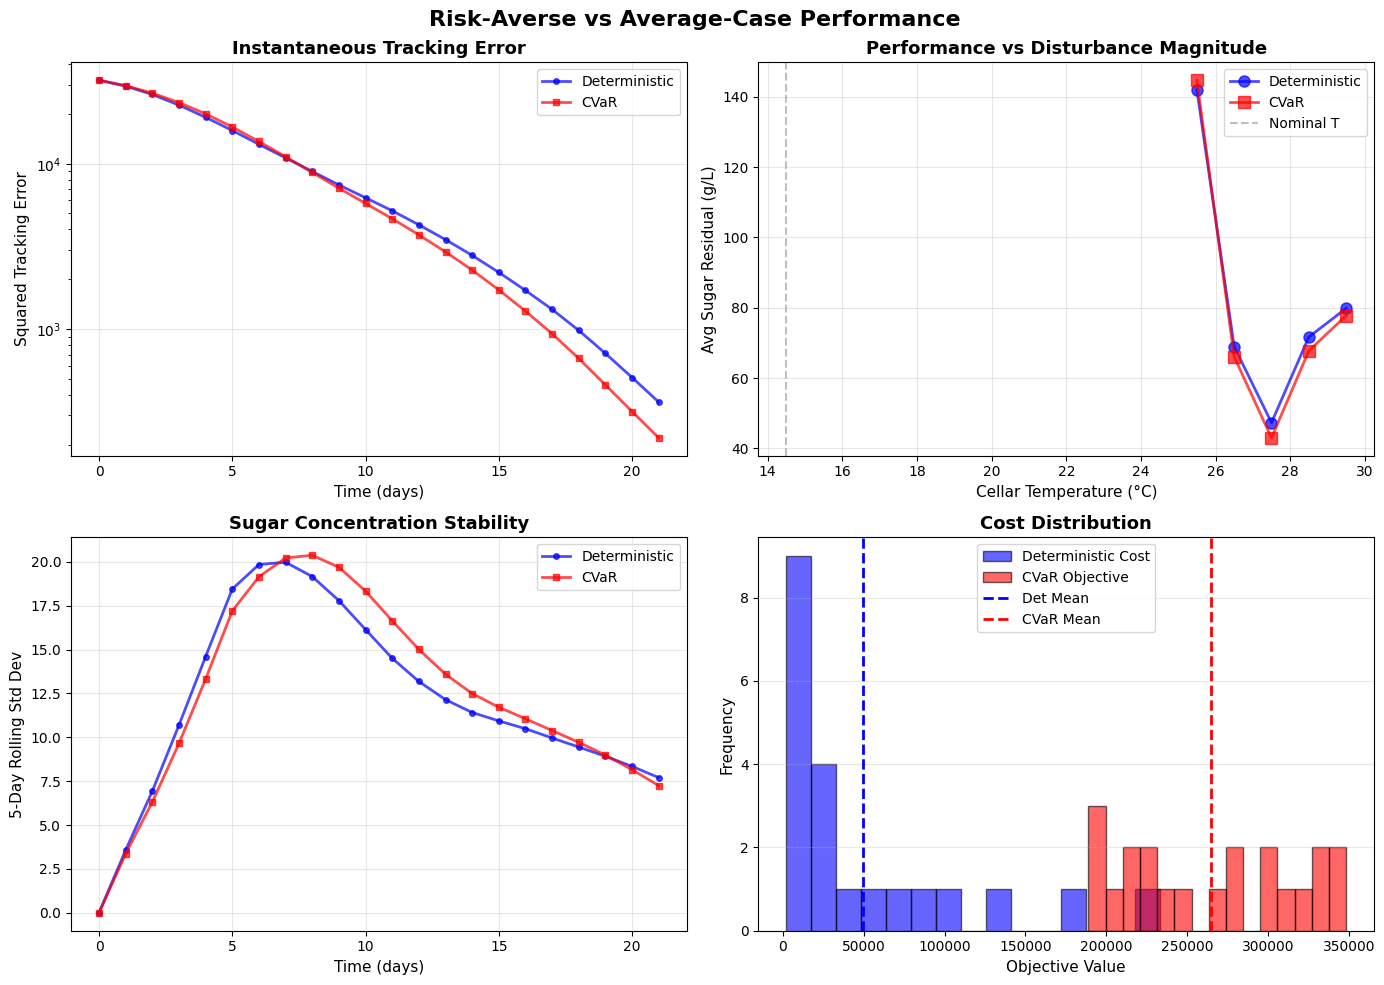

In [40]:
# ============================================================================
# WORST-CASE SCENARIO ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Risk-Averse vs Average-Case Performance", fontsize=16, fontweight="bold")

# Plot 1: Sugar tracking error over time
ax = axes[0, 0]
det_error = (y_hist_det[:, 3] - 0) ** 2
cvar_error = (y_hist_cvar[:, 3] - 0) ** 2
ax.plot(
    t_hist_det_arr,
    det_error,
    "b-o",
    linewidth=2,
    markersize=4,
    label="Deterministic",
    alpha=0.7,
)
ax.plot(
    t_hist_cvar_arr,
    cvar_error,
    "r-s",
    linewidth=2,
    markersize=4,
    label="CVaR",
    alpha=0.7,
)
ax.set_xlabel("Time (days)", fontsize=11)
ax.set_ylabel("Squared Tracking Error", fontsize=11)
ax.set_title("Instantaneous Tracking Error", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale("log")

# Plot 2: Performance vs cellar temperature
ax = axes[0, 1]
# Group by temperature bins
temp_bins = np.linspace(T_cellar_min, T_cellar_max, 6)
det_performance_bins = []
cvar_performance_bins = []
bin_centers = []

for i in range(len(temp_bins) - 1):
    mask = [(t >= temp_bins[i] and t < temp_bins[i + 1]) for t in T_cellar_realized_det]
    if any(mask):
        indices = [j for j, m in enumerate(mask) if m]
        det_avg = np.mean([y_hist_det[j + 1, 3] for j in indices])
        cvar_avg = np.mean([y_hist_cvar[j + 1, 3] for j in indices])
        det_performance_bins.append(det_avg)
        cvar_performance_bins.append(cvar_avg)
        bin_centers.append((temp_bins[i] + temp_bins[i + 1]) / 2)

ax.plot(
    bin_centers,
    det_performance_bins,
    "b-o",
    linewidth=2,
    markersize=8,
    label="Deterministic",
    alpha=0.7,
)
ax.plot(
    bin_centers,
    cvar_performance_bins,
    "r-s",
    linewidth=2,
    markersize=8,
    label="CVaR",
    alpha=0.7,
)
ax.axvline(
    x=T_cellar_nominal, color="gray", linestyle="--", alpha=0.5, label="Nominal T"
)
ax.set_xlabel("Cellar Temperature (°C)", fontsize=11)
ax.set_ylabel("Avg Sugar Residual (g/L)", fontsize=11)
ax.set_title("Performance vs Disturbance Magnitude", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Rolling standard deviation (stability measure)
ax = axes[1, 0]
window = 5
if len(y_hist_det) > window:
    det_rolling_std = [
        np.std(y_hist_det[max(0, i - window) : i + 1, 3])
        for i in range(len(y_hist_det))
    ]
    cvar_rolling_std = [
        np.std(y_hist_cvar[max(0, i - window) : i + 1, 3])
        for i in range(len(y_hist_cvar))
    ]

    ax.plot(
        t_hist_det_arr,
        det_rolling_std,
        "b-o",
        linewidth=2,
        markersize=4,
        label="Deterministic",
        alpha=0.7,
    )
    ax.plot(
        t_hist_cvar_arr,
        cvar_rolling_std,
        "r-s",
        linewidth=2,
        markersize=4,
        label="CVaR",
        alpha=0.7,
    )
    ax.set_xlabel("Time (days)", fontsize=11)
    ax.set_ylabel(f"{window}-Day Rolling Std Dev", fontsize=11)
    ax.set_title("Sugar Concentration Stability", fontsize=13, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Plot 4: Cost distribution (if CVaR tracked costs)
ax = axes[1, 1]
if cost_hist_det and cvar_hist:
    ax.hist(
        cost_hist_det,
        bins=15,
        alpha=0.6,
        color="blue",
        label="Deterministic Cost",
        edgecolor="black",
    )
    ax.hist(
        cvar_hist,
        bins=15,
        alpha=0.6,
        color="red",
        label="CVaR Objective",
        edgecolor="black",
    )
    ax.axvline(
        x=np.mean(cost_hist_det),
        color="blue",
        linestyle="--",
        linewidth=2,
        label="Det Mean",
    )
    ax.axvline(
        x=np.mean(cvar_hist),
        color="red",
        linestyle="--",
        linewidth=2,
        label="CVaR Mean",
    )
    ax.set_xlabel("Objective Value", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.set_title("Cost Distribution", fontsize=13, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [41]:
# ## Hyperparameter Tuning for CVaR MPC

# print("=" * 80)
# print("HYPERPARAMETER TUNING: Finding Optimal α and n_scenarios")
# print("=" * 80)

# # Configuration for hyperparameter search
# alpha_candidates = [0.05, 0.10, 0.15, 0.20, 0.25]
# scenario_candidates = [10, 20, 30, 50]
# n_tuning_iterations = 21  # Run first 5 days for quick evaluation

# # Storage for tuning results
# tuning_results = []

# # Use consistent random seed for fair comparison
# base_seed = 42

# for alpha_test in alpha_candidates:
#     for n_scenarios_test in scenario_candidates:
#         print(f"\nTesting α={alpha_test}, n_scenarios={n_scenarios_test}")

#         # Reset random seed for consistency
#         np.random.seed(base_seed)

#         # Rebuild CVaR solver with new hyperparameters
#         U_tune = SX.sym("U_tune", n_controls, n)
#         P_tune = SX.sym("P_tune", n_states + 1 + n_scenarios_test)
#         eta_tune = SX.sym("eta_tune")
#         z_tune = SX.sym("z_tune", n_scenarios_test)

#         T_scenarios_tune = P_tune[n_states + 1 :]

#         # Simulate scenarios
#         costs_tune = []
#         g_tune = []

#         for s in range(n_scenarios_test):
#             Y_s_tune = SX.sym(f"Y_s_tune{s}", n_states, n + 1)
#             Y_s_tune[:, 0] = P_tune[:n_states]

#             for k in range(n):
#                 st = Y_s_tune[:, k]
#                 con = U_tune[:, k]
#                 T_c = T_scenarios_tune[s]

#                 k1 = f(st, con, T_c)
#                 k2 = f(st + th / 2 * k1, con, T_c)
#                 k3 = f(st + th / 2 * k2, con, T_c)
#                 k4 = f(st + th * k3, con, T_c)

#                 Y_s_tune[:, k + 1] = st + (th / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

#             cost_s_tune = 0
#             for k in range(n):
#                 st = Y_s_tune[3, k]
#                 con = U_tune[:, k]
#                 S_dach = ((P_tune[n_states] - Y_s_tune[3, 0]) / n) * (
#                     k * th
#                 ) + Y_s_tune[3, 0]
#                 cost_s_tune = (
#                     cost_s_tune
#                     + 1 * con * p_fred[18]
#                     + 1 * (st - P_tune[n_states]) ** 2
#                     + 0.01 * (st - S_dach) ** 2
#                 )

#             costs_tune.append(cost_s_tune)

#             for k in range(n):
#                 g_tune.extend(
#                     [
#                         Y_s_tune[0, k],
#                         Y_s_tune[1, k],
#                         Y_s_tune[2, k],
#                         Y_s_tune[3, k],
#                         Y_s_tune[4, k],
#                         Y_s_tune[5, k],
#                     ]
#                 )

#         # CVaR objective with test alpha
#         cvar_obj_tune = eta_tune + (1.0 / (alpha_test * n_scenarios_test)) * sum(z_tune)

#         for s in range(n_scenarios_test):
#             g_tune.append(z_tune[s] - (costs_tune[s] - eta_tune))

#         g_tune = vertcat(*g_tune)

#         # Bounds
#         lbg_tune = []
#         ubg_tune = []
#         for s in range(n_scenarios_test):
#             for k in range(n):
#                 lbg_tune.extend([0, 0, 0, 0, -0.1, 13])
#                 ubg_tune.extend([inf, inf, inf, 178.9, inf, 25])
#         lbg_tune.extend([0] * n_scenarios_test)
#         ubg_tune.extend([inf] * n_scenarios_test)

#         lbx_tune = [0] * (n_controls * n) + [-inf] + [0] * n_scenarios_test
#         ubx_tune = [1] * (n_controls * n) + [inf] + [inf] * n_scenarios_test

#         nlp_tune = {
#             "f": cvar_obj_tune,
#             "x": vertcat(U_tune.reshape((-1, 1)), eta_tune, z_tune),
#             "g": g_tune,
#             "p": P_tune,
#         }

#         opts_tune = {
#             "ipopt": {"max_iter": 3000, "print_level": 0, "acceptable_tol": 1e-6},
#             "print_time": 0,
#         }

#         try:
#             solver_tune = nlpsol("solver_tune", "ipopt", nlp_tune, opts_tune)

#             # Run short simulation to evaluate performance
#             t0_tune = 0
#             y0_tune = DM([0.20, 0.098, 0.0, 178.9, 0.005, 18])
#             Sref_tune = DM([0])

#             u0_tune = DM.zeros((n, n_controls))
#             eta0_tune = DM(0)
#             z0_tune = DM.zeros(n_scenarios_test)

#             cumulative_error = 0
#             avg_cvar = 0
#             solve_times = []

#             for iter_tune in range(n_tuning_iterations):
#                 T_scenarios_sample = sample_cellar_temperatures(n_scenarios_test)

#                 start_time = time()
#                 sol_tune = solver_tune(
#                     x0=vertcat(u0_tune.reshape((-1, 1)), eta0_tune, z0_tune),
#                     lbx=DM(lbx_tune),
#                     ubx=DM(ubx_tune),
#                     lbg=DM(lbg_tune),
#                     ubg=DM(ubg_tune),
#                     p=vertcat(y0_tune, Sref_tune, DM(T_scenarios_sample)),
#                 )
#                 solve_times.append(time() - start_time)

#                 sol_x = sol_tune["x"]
#                 u_tune = reshape(sol_x[: n_controls * n], n_controls, n)
#                 eta0_tune = sol_x[n_controls * n]
#                 z0_tune = sol_x[n_controls * n + 1 :]

#                 T_cellar_actual = np.random.uniform(T_cellar_min, T_cellar_max)
#                 t0_tune, y0_tune, u0_tune = shift_timestep(
#                     th, t0_tune, y0_tune, u_tune, T_cellar_actual, f
#                 )

#                 if y0_tune[4] < 0:
#                     y0_tune[4] = 0

#                 cumulative_error += (float(y0_tune[3]) - float(Sref_tune)) ** 2
#                 avg_cvar += float(sol_tune["f"])

#             avg_cvar /= n_tuning_iterations
#             avg_solve_time = np.mean(solve_times)

#             tuning_results.append(
#                 {
#                     "alpha": alpha_test,
#                     "n_scenarios": n_scenarios_test,
#                     "avg_cvar": avg_cvar,
#                     "cumulative_error": cumulative_error,
#                     "avg_solve_time": avg_solve_time,
#                     "final_sugar": float(y0_tune[3]),
#                 }
#             )

#             print(
#                 f"  ✓ Avg CVaR: {avg_cvar:.2f}, Error: {cumulative_error:.2f}, Time: {avg_solve_time:.3f}s"
#             )

#         except Exception as e:
#             print(f"  ✗ Failed to build/solve: {str(e)[:50]}")
#             tuning_results.append(
#                 {
#                     "alpha": alpha_test,
#                     "n_scenarios": n_scenarios_test,
#                     "avg_cvar": float("inf"),
#                     "cumulative_error": float("inf"),
#                     "avg_solve_time": float("inf"),
#                     "final_sugar": float("inf"),
#                 }
#             )

# # Find best hyperparameters
# print("\n" + "=" * 80)
# print("TUNING RESULTS SUMMARY")
# print("=" * 80)

# # Sort by CVaR value (lower is better)
# tuning_results_sorted = sorted(tuning_results, key=lambda x: x["avg_cvar"])

# print(
#     f"\n{'Rank':<6}{'α':<8}{'Scenarios':<12}{'Avg CVaR':<12}{'Cum Error':<12}{'Solve Time':<12}{'Final Sugar':<12}"
# )
# print("-" * 80)

# for i, result in enumerate(tuning_results_sorted[:10], 1):
#     if result["avg_cvar"] != float("inf"):
#         print(
#             f"{i:<6}{result['alpha']:<8}{result['n_scenarios']:<12}{result['avg_cvar']:<12.2f}"
#             f"{result['cumulative_error']:<12.2f}{result['avg_solve_time']:<12.3f}{result['final_sugar']:<12.2f}"
#         )

# # Recommend best configuration
# best_config = tuning_results_sorted[0]
# print("\n" + "=" * 80)
# print("RECOMMENDED HYPERPARAMETERS")
# print("=" * 80)
# print(f"  α (risk level):        {best_config['alpha']}")
# print(f"  n_scenarios:           {best_config['n_scenarios']}")
# print(f"  Expected avg CVaR:     {best_config['avg_cvar']:.2f}")
# print(f"  Expected tracking error: {best_config['cumulative_error']:.2f}")
# print(f"  Avg solve time:        {best_config['avg_solve_time']:.3f}s")
# print("=" * 80)

# # Visualize tuning results
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle("CVaR Hyperparameter Tuning Results", fontsize=16, fontweight="bold")

# # Plot 1: CVaR vs α for different scenario counts
# ax = axes[0, 0]
# for n_scen in scenario_candidates:
#     subset = [
#         r
#         for r in tuning_results
#         if r["n_scenarios"] == n_scen and r["avg_cvar"] != float("inf")
#     ]
#     if subset:
#         alphas = [r["alpha"] for r in subset]
#         cvars = [r["avg_cvar"] for r in subset]
#         ax.plot(
#             alphas, cvars, "-o", label=f"{n_scen} scenarios", linewidth=2, markersize=6
#         )
# ax.set_xlabel("α (risk level)", fontsize=11)
# ax.set_ylabel("Average CVaR Value", fontsize=11)
# ax.set_title("CVaR vs Risk Level", fontsize=13, fontweight="bold")
# ax.legend()
# ax.grid(True, alpha=0.3)

# # Plot 2: Tracking error vs α
# ax = axes[0, 1]
# for n_scen in scenario_candidates:
#     subset = [
#         r
#         for r in tuning_results
#         if r["n_scenarios"] == n_scen and r["cumulative_error"] != float("inf")
#     ]
#     if subset:
#         alphas = [r["alpha"] for r in subset]
#         errors = [r["cumulative_error"] for r in subset]
#         ax.plot(
#             alphas, errors, "-s", label=f"{n_scen} scenarios", linewidth=2, markersize=6
#         )
# ax.set_xlabel("α (risk level)", fontsize=11)
# ax.set_ylabel("Cumulative Tracking Error", fontsize=11)
# ax.set_title("Tracking Error vs Risk Level", fontsize=13, fontweight="bold")
# ax.legend()
# ax.grid(True, alpha=0.3)

# # Plot 3: CVaR vs number of scenarios
# ax = axes[1, 0]
# for alpha_val in alpha_candidates:
#     subset = [
#         r
#         for r in tuning_results
#         if r["alpha"] == alpha_val and r["avg_cvar"] != float("inf")
#     ]
#     if subset:
#         scenarios = [r["n_scenarios"] for r in subset]
#         cvars = [r["avg_cvar"] for r in subset]
#         ax.plot(
#             scenarios, cvars, "-o", label=f"α={alpha_val}", linewidth=2, markersize=6
#         )
# ax.set_xlabel("Number of Scenarios", fontsize=11)
# ax.set_ylabel("Average CVaR Value", fontsize=11)
# ax.set_title("CVaR vs Scenario Count", fontsize=13, fontweight="bold")
# ax.legend()
# ax.grid(True, alpha=0.3)

# # Plot 4: Solve time vs configuration
# ax = axes[1, 1]
# valid_results = [r for r in tuning_results if r["avg_solve_time"] != float("inf")]
# if valid_results:
#     config_labels = [f"α={r['alpha']}\nn={r['n_scenarios']}" for r in valid_results]
#     solve_times = [r["avg_solve_time"] for r in valid_results]
#     cvars = [r["avg_cvar"] for r in valid_results]

#     scatter = ax.scatter(
#         solve_times,
#         cvars,
#         s=100,
#         c=range(len(valid_results)),
#         cmap="viridis",
#         alpha=0.6,
#     )

#     # Annotate best configuration
#     best_idx = valid_results.index(best_config)
#     ax.scatter(
#         [best_config["avg_solve_time"]],
#         [best_config["avg_cvar"]],
#         s=200,
#         c="red",
#         marker="*",
#         edgecolors="black",
#         linewidths=2,
#         label="Best Config",
#         zorder=5,
#     )

#     ax.set_xlabel("Average Solve Time (s)", fontsize=11)
#     ax.set_ylabel("Average CVaR Value", fontsize=11)
#     ax.set_title("CVaR vs Computational Cost", fontsize=13, fontweight="bold")
#     ax.legend()
#     ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print(f"\n✓ Hyperparameter tuning complete!")
# print(
#     f"  Update your configuration with: alpha={best_config['alpha']}, n_scenarios={best_config['n_scenarios']}"
# )